In [ ]:
## Set seeds for reproducibilitys
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

## Importing the dependencies


import os
import json
import random
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

### Kaggle key

In [2]:
try:
    kaggle_credentials = json.load(open("kaggle.json"))
    os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
    os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]
except FileNotFoundError:
    print("kaggle.json file not found. Please place it in the directory.")
except KeyError:
    print("Error: Invalid JSON format in kaggle.json.")

In [3]:
import kaggle
from zipfile import ZipFile

# Define dataset name and zip file name
dataset_name = 'fashionData'
zip_file_name = 'fashionData.zip'

# Check if the dataset folder exists
if not os.path.exists(dataset_name): 
    # Check if the zip file exists
    if not os.path.exists(zip_file_name):
        # Use Kaggle API to download the dataset
        kaggle.api.dataset_download_files("bhavikjikadara/e-commerce-products-images", path='.', unzip=False)
        
    # Extract the dataset if the directory doesn't exist
    with ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(dataset_name)

print(f"Dataset is ready and extracted in '{dataset_name}' directory.")

Dataset is ready and extracted in 'fashionData' directory.


In [4]:
styles = pd.read_csv(r"C:\Users\pascal\Desktop\New Projects\AI-Driven-Image-Classification-for-Fashion-Retailer\fashionData\styles.csv")
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
styles.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [6]:
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44441 non-null  int64  
 1   gender              44441 non-null  object 
 2   masterCategory      44441 non-null  object 
 3   subCategory         44441 non-null  object 
 4   articleType         44441 non-null  object 
 5   baseColour          44426 non-null  object 
 6   season              44420 non-null  object 
 7   year                44440 non-null  float64
 8   usage               44124 non-null  object 
 9   productDisplayName  44434 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [7]:
duplicates = styles.duplicated().sum()
duplicates

0

In [8]:
# Updated color mapping dictionary based on unique baseColour values
color_mapping = {
    'Navy Blue': 'Blue', 'Blue': 'Blue', 'Turquoise Blue': 'Blue', 'Teal': 'Blue', 'Steel': 'Gray',
    'Silver': 'Gray', 'Grey': 'Gray', 'Charcoal': 'Gray', 'Grey Melange': 'Gray',
    'Green': 'Green', 'Olive': 'Green', 'Lime Green': 'Green', 'Sea Green': 'Green', 'Fluorescent Green': 'Green',
    'Purple': 'Purple', 'Lavender': 'Purple', 'Mauve': 'Purple', 'Magenta': 'Purple',
    'Black': 'Black', 'White': 'White', 'Off White': 'White', 'Cream': 'White',
    'Beige': 'Beige', 'Khaki': 'Beige', 'Skin': 'Beige', 'Taupe': 'Beige',
    'Brown': 'Brown', 'Coffee Brown': 'Brown', 'Mushroom Brown': 'Brown', 'Tan': 'Brown', 'Bronze': 'Brown', 'Copper': 'Brown',
    'Red': 'Red', 'Maroon': 'Red', 'Burgundy': 'Red', 'Rose': 'Pink', 'Pink': 'Pink',
    'Yellow': 'Yellow', 'Mustard': 'Yellow', 'Gold': 'Yellow',
    'Orange': 'Orange', 'Peach': 'Orange', 'Rust': 'Orange',
    'Multi': 'Multi', 'Metallic': 'Multi', 'Nude': 'Other'
}

# Apply the mapping to create a new column for the broader color categories
styles['mainColor'] = styles['baseColour'].map(color_mapping).fillna('Other')

# Check the unique values in the new mainColor column to verify the mapping
print(styles['mainColor'].unique())


['Blue' 'Gray' 'Black' 'Green' 'Purple' 'White' 'Beige' 'Brown' 'Pink'
 'Red' 'Orange' 'Yellow' 'Multi' 'Other']


Column: masterCategory
Unique Values: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']




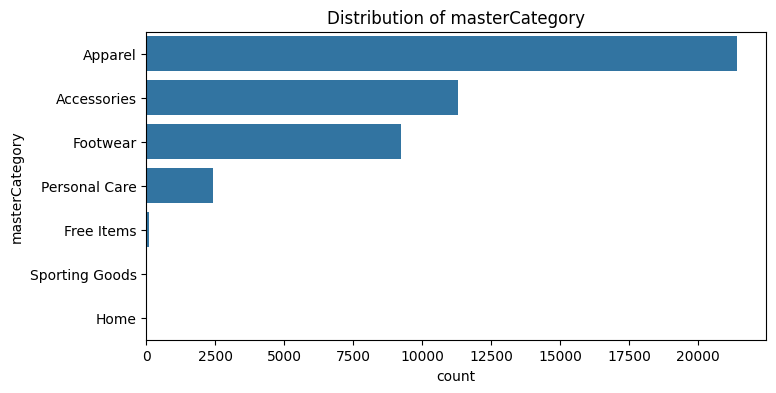

Column: gender
Unique Values: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']




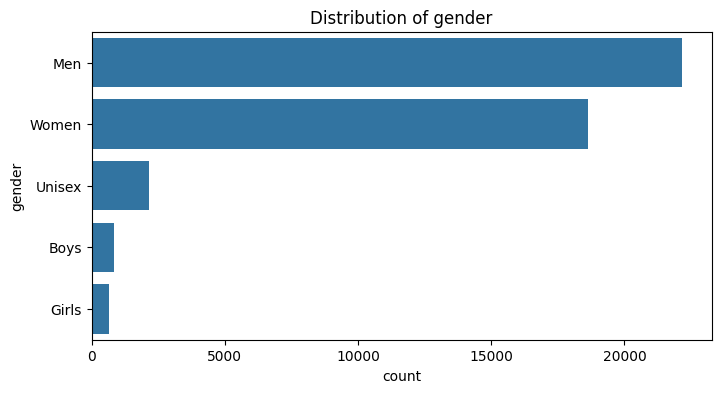

Column: mainColor
Unique Values: ['Blue' 'Gray' 'Black' 'Green' 'Purple' 'White' 'Beige' 'Brown' 'Pink'
 'Red' 'Orange' 'Yellow' 'Multi' 'Other']




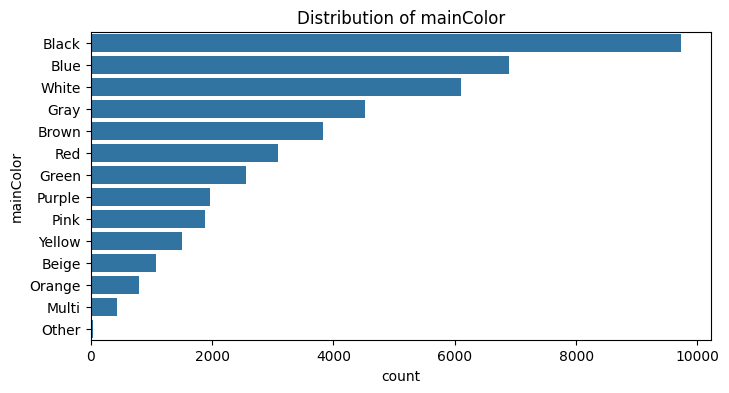

Column: usage
Unique Values: ['Casual' 'Ethnic' 'Formal' 'Sports' nan 'Smart Casual' 'Travel' 'Party'
 'Home']




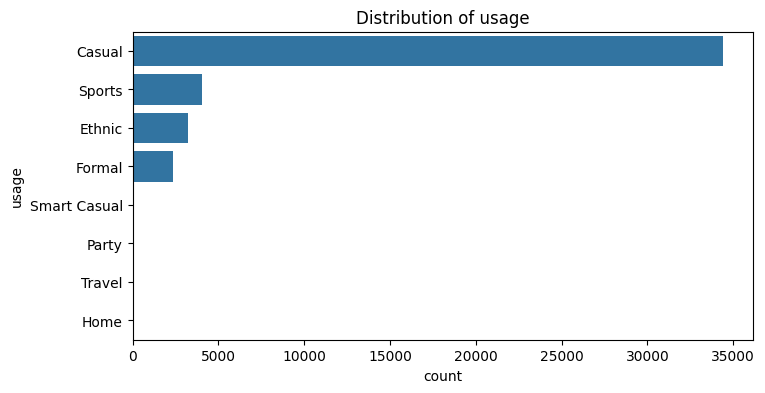

Column: season
Unique Values: ['Fall' 'Summer' 'Winter' 'Spring' nan]




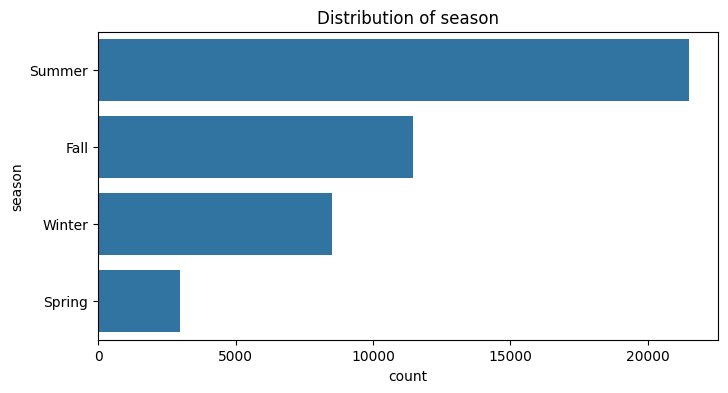

In [9]:


def explore_selected_columns(df):
    # List of columns to explore
    columns_to_explore = ['masterCategory', 'gender', 'mainColor', 'usage', 'season']
    
    # Loop through each selected column
    for column in columns_to_explore:
        if column in df.columns:
            # Check if the column is of type object (string/categorical data)
            if df[column].dtype == 'object':
                print(f"Column: {column}")
                print("Unique Values:", df[column].unique())
                print("\n")
                
                # Plot distribution for categorical columns
                plt.figure(figsize=(8, 4))
                sns.countplot(y=column, data=df, order=df[column].value_counts().index)
                plt.title(f"Distribution of {column}")
                plt.show()
            
            # If the column is numerical, plot a histogram
            elif df[column].dtype in ['int64', 'float64']:
                print(f"Column: {column}")
                print("Statistical Summary:")
                print(df[column].describe())
                print("\n")
                
                # Plot distribution for numerical columns
                plt.figure(figsize=(8, 4))
                sns.histplot(df[column], kde=True)
                plt.title(f"Distribution of {column}")
                plt.xlabel(column)
                plt.show()

# Usage
explore_selected_columns(styles)
